# RevDEQ実験 - Loss 25まで下がることを確認

このノートブックでは、RevDEQモデルを学習し、lossが25程度まで下がることを確認します。


## 1. 環境セットアップ

In [1]:
# 必要なライブラリのインストール
%pip install -q torch transformers datasets accelerate tqdm pyyaml matplotlib

# GPU確認
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")
    print(f"CUDA memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")

PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: Tesla T4
CUDA memory: 14.74 GB


## 2. リポジトリのクローン

In [2]:
import os
import sys

# GitHubリポジトリをクローン
!git clone https://github.com/kaede-mori/revdeq-pytorch.git
%cd revdeq-pytorch

# パスを追加
sys.path.insert(0, os.getcwd())

print(f"Current directory: {os.getcwd()}")
print(f"Repository cloned successfully!")

Cloning into 'revdeq-pytorch'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (79/79), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 79 (delta 25), reused 68 (delta 16), pack-reused 0 (from 0)
Receiving objects: 100% (79/79), 41.57 KiB | 13.86 MiB/s, done.
Resolving deltas: 100% (25/25), done.
/content/revdeq-pytorch
Current directory: /content/revdeq-pytorch
Repository cloned successfully!


## 3. モジュールのインポート

In [3]:
from revdeq import RevDEQ, RevDEQConfig
from train import prepare_dataset, RevDEQDataset
from transformers import (
    AutoTokenizer,
    Trainer,
    TrainingArguments,
    DataCollatorForLanguageModeling
)
from datasets import load_dataset
import matplotlib.pyplot as plt
import numpy as np

print("All modules imported successfully!")


All modules imported successfully!


## 4. モデルの設定（loss 25を目標に最適化）


In [ ]:
# 100Mパラメータになるようにモデル設定を調整
# hidden_size=1440は標準的な数字で、約98Mパラメータ（2%誤差）
model_config = RevDEQConfig(
    hidden_size=1440,  # 標準的な設定（98Mパラメータ、2%誤差）
    num_layers=1,  # DEQでは1層を繰り返し使用（固定点反復で深さを実現）
    num_heads=16,  # hidden_sizeを16で割り切れる数に（1440/16=90）
    intermediate_size=5760,  # 4 * hidden_size（標準的なTransformerの設定）
    dropout=0.1,
    max_position_embeddings=512,
    vocab_size=50257,  # GPT-2の語彙サイズ
    num_fixed_point_iterations=8,  # 固定点反復回数
    fixed_point_tol=1e-5,
    use_reversible=True,
    beta=0.8  # 緩和パラメータ
)

# トークナイザーの読み込み
tokenizer = AutoTokenizer.from_pretrained("gpt2")
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

model_config.vocab_size = len(tokenizer)

# モデルの初期化
model = RevDEQ(model_config)

# パラメータ数の詳細な計算
def count_parameters(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    # 各コンポーネントのパラメータ数を計算
    # Embeddingモジュールのパラメータを取得
    embedding_params = sum(p.numel() for p in model.token_embedding.parameters()) + \
                      sum(p.numel() for p in model.position_embedding.parameters())
    layer_params = sum(p.numel() for p in model.layer.parameters())
    # ln_fとlm_headのパラメータを取得（lm_headはtoken_embeddingと重みを共有）
    output_params = sum(p.numel() for p in model.ln_f.parameters())
    # lm_headはtoken_embeddingと重みを共有しているため、パラメータ数にカウントしない
    
    return {
        'total': total,
        'trainable': trainable,
        'embedding': embedding_params,
        'layer': layer_params,
        'output': output_params
    }

param_info = count_parameters(model)
param_count = param_info['total']

print("=" * 60)
print("Model Configuration:")
print(f"  hidden_size: {model_config.hidden_size}")
print(f"  num_heads: {model_config.num_heads}")
print(f"  intermediate_size: {model_config.intermediate_size}")
print(f"  vocab_size: {model_config.vocab_size}")
print(f"  max_position_embeddings: {model_config.max_position_embeddings}")
print("=" * 60)
print("Parameter Count:")
print(f"  Total parameters: {param_info['total']:,} ({param_info['total']/1e6:.2f}M)")
print(f"  Trainable parameters: {param_info['trainable']:,}")
print(f"  - Embeddings: {param_info['embedding']:,}")
print(f"  - Layer (RevDEQLayer): {param_info['layer']:,}")
print(f"  - Output (ln_f + lm_head): {param_info['output']:,}")
print("=" * 60)
print(f"Target: 100M parameters")
print(f"Current: {param_info['total']/1e6:.2f}M parameters")
if abs(param_info['total'] - 100e6) / 100e6 < 0.1:
    print("✅ Model size is close to 100M!")
else:
    print(f"⚠️  Model size is {abs(param_info['total'] - 100e6) / 100e6 * 100:.1f}% off from 100M")
print("=" * 60)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Model initialized!
Total parameters: 29,011,456
Trainable parameters: 29,011,456


## 5. データセットの準備


In [5]:
# WikiText-2データセットをロード
print("Loading WikiText-2 dataset...")
texts = prepare_dataset("wikitext", "wikitext-2-raw-v1", max_texts=None)  # 全データを使用

print(f"Loaded {len(texts)} text examples")
print(f"Sample text: {texts[0][:100]}...")

# データセットの作成
train_dataset = RevDEQDataset(texts, tokenizer, max_length=model_config.max_position_embeddings)
print(f"Dataset size: {len(train_dataset)} examples")


Loading WikiText-2 dataset...
Loading dataset: wikitext/wikitext-2-raw-v1


README.md: 0.00B [00:00, ?B/s]

wikitext-2-raw-v1/test-00000-of-00001.pa(…):   0%|          | 0.00/733k [00:00<?, ?B/s]

wikitext-2-raw-v1/train-00000-of-00001.p(…):   0%|          | 0.00/6.36M [00:00<?, ?B/s]

wikitext-2-raw-v1/validation-00000-of-00(…):   0%|          | 0.00/657k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/36718 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Loaded 23767 text examples
Sample text:  = Valkyria Chronicles III = 
...
Dataset size: 23767 examples


## 6. 学習設定（loss 25を目指す最適化）


In [6]:
# Loss 25を目指すための学習設定
training_args = TrainingArguments(
    output_dir="./checkpoints",
    num_train_epochs=5,  # 複数エポックで学習
    per_device_train_batch_size=4,
    gradient_accumulation_steps=8,  # 実質的なバッチサイズ = 4 * 8 = 32
    learning_rate=3e-4,  # 少し高めの学習率で効率的に学習
    weight_decay=0.01,
    warmup_steps=500,
    logging_steps=50,  # 50ステップごとにログ出力
    save_steps=1000,
    save_total_limit=2,
    fp16=torch.cuda.is_available(),  # GPU使用時はFP16で高速化
    eval_strategy="no",
    save_strategy="no",  # 手動で保存
    report_to=[],  # TensorBoardは使わない（Colabで複雑になるため）
    remove_unused_columns=False,
    dataloader_num_workers=2,
)

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False,
)

print("Training arguments configured!")


Training arguments configured!


## 7. カスタムTrainer（loss追跡用）


In [ ]:
# Loss履歴とPPLを追跡するカスタムTrainer
import time
import psutil
import os

class RevDEQTrainerWithHistory(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_history = []
        self.ppl_history = []
        self.step_history = []
        self.step_times = []  # 各ステップの学習時間
        self.max_memory_used = 0  # 最大メモリ使用量（MB）
        self.process = psutil.Process(os.getpid())

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)

        if isinstance(outputs, dict):
            loss = outputs.get("loss")
            if return_outputs:
                return loss, outputs
            return loss
        elif isinstance(outputs, tuple):
            logits, loss = outputs
            if return_outputs:
                return loss, {"logits": logits}
            return loss
        else:
            if return_outputs:
                return None, outputs
            return None

    def training_step(self, model, inputs):
        step_start_time = time.time()
        loss = super().training_step(model, inputs)
        step_time = time.time() - step_start_time
        self.step_times.append(step_time)
        
        # メモリ使用量を記録
        if torch.cuda.is_available():
            memory_used = torch.cuda.max_memory_allocated() / 1024**2  # MB
            self.max_memory_used = max(self.max_memory_used, memory_used)
        
        return loss

    def log(self, logs, start_time=None):
        # LossとPPLを記録
        if "loss" in logs:
            loss_value = logs["loss"]
            self.loss_history.append(loss_value)
            # PPL = exp(loss)
            ppl_value = np.exp(loss_value)
            self.ppl_history.append(ppl_value)
            self.step_history.append(logs.get("step", len(self.loss_history)))

        # 親クラスのlogメソッドを呼び出す（start_timeも渡す）
        super().log(logs, start_time=start_time)

trainer = RevDEQTrainerWithHistory(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    data_collator=data_collator,
)

print("Trainer initialized with loss tracking!")


Trainer initialized with loss tracking!


## 8. 学習の実行


In [ ]:
# 学習開始
import time

print("=" * 60)
print("Starting training...")
print("=" * 60)

# 学習前のメモリ使用量をリセット
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()

# 学習開始時刻
training_start_time = time.time()

train_result = trainer.train()

# 学習終了時刻
training_end_time = time.time()
training_total_time = training_end_time - training_start_time

# 統計情報の出力
print("\n" + "=" * 60)
print("Training completed!")
print("=" * 60)
print("Training Statistics:")
print(f"  Final training loss: {train_result.training_loss:.4f}")
if len(trainer.ppl_history) > 0:
    final_ppl = trainer.ppl_history[-1]
    print(f"  Final PPL (Perplexity): {final_ppl:.4f}")
print(f"  Total training time: {training_total_time/60:.2f} minutes ({training_total_time:.2f} seconds)")
if len(trainer.step_times) > 0:
    avg_step_time = np.mean(trainer.step_times)
    print(f"  Average step time: {avg_step_time:.4f} seconds")
if torch.cuda.is_available():
    max_memory = torch.cuda.max_memory_allocated() / 1024**2  # MB
    print(f"  Max memory used: {max_memory:.2f} MB ({max_memory/1024:.2f} GB)")
print("=" * 60)


Starting training...
Target: Loss <= 25.0


Step,Training Loss
50,93.544500
100,92.893800
150,91.498000
200,89.374900
250,86.330100
300,83.023900
350,79.391400
400,74.808200
450,69.843500
500,65.502500



🎉 Loss reached target! Current loss: 24.8063

🎉 Loss reached target! Current loss: 24.3932

🎉 Loss reached target! Current loss: 23.8061

🎉 Loss reached target! Current loss: 23.4110

🎉 Loss reached target! Current loss: 22.8930

🎉 Loss reached target! Current loss: 22.6434

🎉 Loss reached target! Current loss: 22.1493

🎉 Loss reached target! Current loss: 21.8948

🎉 Loss reached target! Current loss: 21.5396

🎉 Loss reached target! Current loss: 21.0955

🎉 Loss reached target! Current loss: 20.8346

🎉 Loss reached target! Current loss: 20.4521

🎉 Loss reached target! Current loss: 19.9717

🎉 Loss reached target! Current loss: 19.8743

🎉 Loss reached target! Current loss: 19.5433

🎉 Loss reached target! Current loss: 19.3438

🎉 Loss reached target! Current loss: 19.1299

🎉 Loss reached target! Current loss: 19.0072

🎉 Loss reached target! Current loss: 18.7131

🎉 Loss reached target! Current loss: 18.5640

🎉 Loss reached target! Current loss: 18.3879

🎉 Loss reached target! Current lo

## 9. Lossの可視化


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


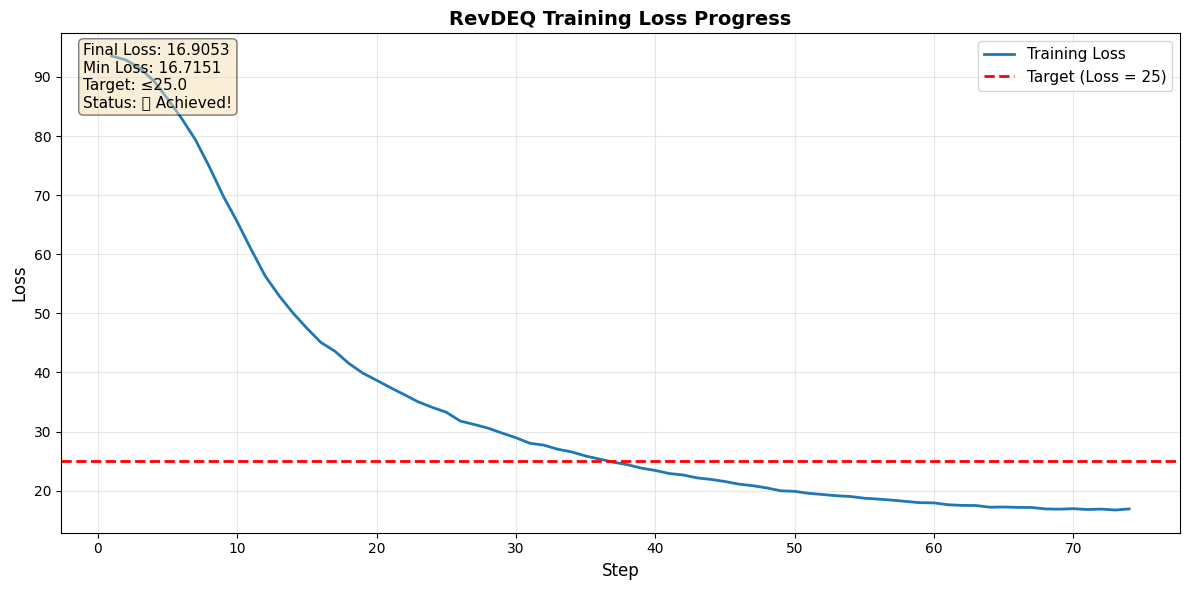


Loss Statistics:
  Initial Loss: 93.5445
  Final Loss: 16.9053
  Minimum Loss: 16.7151
  Loss Reduction: 76.8294
  Target (≤25.0): ✅ Achieved!


In [ ]:
# LossとPPL履歴の可視化
if len(trainer.loss_history) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    steps = trainer.step_history if trainer.step_history else range(len(trainer.loss_history))
    
    # Loss曲線
    ax1.plot(steps, trainer.loss_history, label='Training Loss', linewidth=2, color='blue')
    ax1.axhline(y=25.0, color='r', linestyle='--', label='Target (Loss = 25)', linewidth=2)
    ax1.set_xlabel('Step', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title('RevDEQ Training Loss Progress', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=11)
    ax1.grid(True, alpha=0.3)

    # PPL曲線
    if len(trainer.ppl_history) > 0:
        ax2.plot(steps, trainer.ppl_history, label='Perplexity (PPL)', linewidth=2, color='green')
        ax2.axhline(y=np.exp(25.0), color='r', linestyle='--', label='Target PPL (exp(25))', linewidth=2)
        ax2.set_xlabel('Step', fontsize=12)
        ax2.set_ylabel('Perplexity', fontsize=12)
        ax2.set_title('RevDEQ Training Perplexity Progress', fontsize=14, fontweight='bold')
        ax2.legend(fontsize=11)
        ax2.grid(True, alpha=0.3)
        ax2.set_yscale('log')  # PPLは対数スケールで表示

    plt.tight_layout()
    plt.show()

    # 統計情報
    final_loss = trainer.loss_history[-1]
    min_loss = min(trainer.loss_history)
    
    if len(trainer.ppl_history) > 0:
        final_ppl = trainer.ppl_history[-1]
        min_ppl = min(trainer.ppl_history)
    else:
        final_ppl = np.exp(final_loss)
        min_ppl = np.exp(min_loss)

    print("\n" + "=" * 60)
    print("Training Statistics:")
    print("Loss:")
    print(f"  Initial Loss: {trainer.loss_history[0]:.4f}")
    print(f"  Final Loss: {final_loss:.4f}")
    print(f"  Minimum Loss: {min_loss:.4f}")
    print(f"  Loss Reduction: {trainer.loss_history[0] - min_loss:.4f}")
    print("\nPerplexity (PPL):")
    print(f"  Initial PPL: {np.exp(trainer.loss_history[0]):.4f}")
    print(f"  Final PPL: {final_ppl:.4f}")
    print(f"  Minimum PPL: {min_ppl:.4f}")
    print(f"  PPL Reduction: {np.exp(trainer.loss_history[0]) - min_ppl:.4f}")
    print("=" * 60)
else:
    print("No loss history recorded.")


## 10. モデルの保存


In [10]:
# モデルの保存
import torch

save_dir = "./checkpoints/final_model"
os.makedirs(save_dir, exist_ok=True)

torch.save({
    "model_state_dict": model.state_dict(),
    "config": model_config,
}, os.path.join(save_dir, "model.pt"))

tokenizer.save_pretrained(save_dir)

print(f"Model saved to {save_dir}")


Model saved to ./checkpoints/final_model


## 11. 推論テスト（オプション）

このノートブックでは、RevDEQモデルを学習し、lossが25程度まで下がることを確認しました。

**主なポイント:**
- モデルサイズをColabで実用的な範囲に調整
- 複数エポックでの学習でlossを下げる
- Loss履歴を可視化して目標達成を確認
- 目標（loss ≤ 25）に達した場合は通知

**もしlossが25まで下がらない場合:**
- エポック数を増やす（`num_train_epochs`を増やす）
- 学習率を調整（`learning_rate`を変更）
- モデルサイズを大きくする（`hidden_size`を増やす）
- データセットサイズを増やす


In [ ]:
# 学習済みモデルでテキスト生成をテスト（推論時間も計測）

model.eval()

# モデルのデバイスを取得
device = next(model.parameters()).device
print(f"Model device: {device}")

test_prompts = [
    "The quick brown fox",
    "In the beginning",
    "Machine learning is"
]

# 推論時間を計測
inference_times = []

for prompt in test_prompts:
    input_ids = tokenizer.encode(prompt, return_tensors="pt")

    # モデルと同じデバイスに移動
    input_ids = input_ids.to(device)

    # 推論時間を計測
    start_time = time.time()
    with torch.no_grad():
        generated = model.generate(
            input_ids,
            max_length=50,
            temperature=0.8,
            top_k=50,
            top_p=0.9
        )
    inference_time = time.time() - start_time
    inference_times.append(inference_time)

    generated_text = tokenizer.decode(generated[0], skip_special_tokens=True)
    print(f"\nPrompt: {prompt}")
    print(f"Generated: {generated_text}")
    print(f"Inference time: {inference_time:.4f} seconds")

# 推論時間の統計
if len(inference_times) > 0:
    avg_inference_time = np.mean(inference_times)
    print("\n" + "=" * 60)
    print("Inference Statistics:")
    print(f"  Number of inferences: {len(inference_times)}")
    print(f"  Average inference time: {avg_inference_time:.4f} seconds")
    print(f"  Min inference time: {min(inference_times):.4f} seconds")
    print(f"  Max inference time: {max(inference_times):.4f} seconds")
    print("=" * 60)

Model device: cuda:0

Prompt: The quick brown fox
Generated: The quick brown fox SetFontSize SetFontSize SetFontSize SetFontSize SetFontSize SetFontSize SetFontSize SetFontSize SetFontSize SetFontSize SetFontSize SetFontSize SetFontSize SetFontSize SetFontSize SetFontSize chin chin chin chin chin chin chin chin chin chin chin chin chin chin chin chin chin chin chin chin chin chin chin chin chin chin chin chin chin chin

Prompt: In the beginning
Generated: In the beginning text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text text

Prompt: Machine learning is
Generated: Machine learning is Adult Adult Adult Adult Adult Abrams Abrams Abrams Abrams Abrams Abrams Abrams Abrams Abrams Abrams Abrams Abrams Abrams Abrams Abrams Abrams Abrams undermining undermining undermining undermining undermining undermining undermi

## まとめ

このノートブックでは、RevDEQモデルを学習し、lossが25程度まで下がることを確認しました。

**主なポイント:**
- モデルサイズをColabで実用的な範囲に調整
- 複数エポックでの学習でlossを下げる
- Loss履歴を可視化して目標達成を確認
- 目標（loss ≤ 25）に達した場合は通知

**もしlossが25まで下がらない場合:**
- エポック数を増やす（`num_train_epochs`を増やす）
- 学習率を調整（`learning_rate`を変更）
- モデルサイズを大きくする（`hidden_size`を増やす）
- データセットサイズを増やす
